In [1]:
import pandas as pd
data_sql = pd.read_csv('outs/data_sql_out.csv')
data_llama3 = pd.read_csv('outs/data_agent_out_llama_3.csv')
data_llama3_vllm = pd.read_csv('outs/data_agent_out_llama_3_vllm.csv')
data_llama3_vllm_new = pd.read_csv('outs/data_agent_out_llama_3_vllm_new.csv')
data_deepseek = pd.read_csv('outs/data_agent_out_deepseek_coder.csv')
data_deepseek_vllm = pd.read_csv('outs/data_agent_out_deepseek_coder_vllm.csv')
data_deepseek_vllm_new = pd.read_csv('outs/data_agent_out_deepseek_coder_vllm_new.csv')

In [2]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///data/catastici.db")

### Response post processing

In [3]:
from collections import Counter
import pandas as pd
import numpy as np
import ast
import re
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt

# post processing scripts
def clean_query(sql_query):
    """clean the output"""
    # change to list
    sql_query_list = ast.literal_eval(sql_query)
    
    # split on ;
    sql_query_list = [query.split(';')[0].strip() + ';' for query in sql_query_list]
    # sql_query_list = [query.split(';')[0].split('[/SQL]')[0].strip() + ';' for query in sql_query_list]
    
    # replace ' with ''
    sql_query_list = [re.sub(r"([a-z])'([a-z])",r"\1''\2", query) for query in sql_query_list]

    return sql_query_list

def check_sql_executability(query, db):
    try:
        return db.run(query)
    except Exception as e:
        return str(e)
     
def find_most_common_answer(answers):
    answers = ["ERROR" if "error" in answer else answer for answer in answers]
    most_common_answer, most_common_count = Counter(answers).most_common(1)[0]
    if most_common_answer == "ERROR":
        if most_common_count == 4:
            return most_common_answer
        else:
            return Counter(answers).most_common(2)[1][0]

    return most_common_answer

def clean_answer(answer, to_replace = ['[', ']', '(', ',)', "'", ')']):
    pattern = '|'.join(map(re.escape, to_replace))
    cleaned_answer = re.sub(pattern, '', answer)
    return [ans.strip() for ans in cleaned_answer.split(',')]

def ngram_overlap(true_answer, generated_answer):
    """Calculates 1-gram overlap"""
    # Convert lists to sets to remove duplicates
    true_set = set(true_answer)
    generated_set = set(generated_answer)
    
    # Calculate the intersection of the sets
    overlap_count = len(true_set.intersection(generated_set))
    
    # Calculate the percentage of overlap
    overlap_percentage = overlap_count / len(true_set) if len(true_set) > 0 else 0.0
    
    return round(overlap_percentage, 3)

def get_occurance_in_chat(true_answer, chat):
    true_set = set(true_answer)
    mean_occurance = np.mean([answer in chat for answer in true_set])
    
    return round(mean_occurance, 3)

def get_occurance_in_last_message(true_answer, chat):
    if chat == "ERROR":
        return 0
    true_set = set(true_answer)
    last_message = eval(chat)[-1]['content']
    mean_occurance = np.mean([answer in last_message for answer in true_set])
    
    return round(mean_occurance, 3)

In [4]:
# get clean generated output
for idx, row in data_sql.iterrows():
    query_list_clean = clean_query(row['generated_query'])
    final_out = None
    answers = []
    for out in query_list_clean:
        answers.append(check_sql_executability(out, db))
    answer = find_most_common_answer(answers)
    
    if answer != "ERROR":
        final_out = query_list_clean[answers.index(answer)]
    if final_out == None:
        final_out = query_list_clean[0]
        answer = check_sql_executability(final_out, db)
    data_sql.loc[idx,'generated_answer'] = answer
    data_sql.loc[idx,'generated_query'] = final_out

In [5]:
# get ground truth
for idx, row in data_sql.iterrows():
    answer = check_sql_executability(row['query'], db)
    data_sql.loc[idx,'true_answer'] = answer

In [6]:
# clean the sql output
data_sql['true_answer'].fillna('',inplace=True)
data_sql['true'] = data_sql['true_answer'].apply(clean_answer)
data_sql['sql'] = data_sql['generated_answer'].apply(clean_answer)
data_sql = data_sql[['question','true','sql']]

In [8]:
# merge all outputs into a single dataframe
data = pd.merge(data_sql, data_deepseek, on='question')
data = pd.merge(data, data_deepseek_vllm, on='question')
data = pd.merge(data, data_deepseek_vllm_new, on='question')
data = pd.merge(data, data_llama3, on='question')
data = pd.merge(data, data_llama3_vllm, on='question')
data = pd.merge(data, data_llama3_vllm_new, on='question')
data.sample(1)

,question,true,sql,chat_history_deepseek_coder,chat_history_deepseek_coder_vllm,chat_history_deepseek_coder_vllm_new,chat_history_llama_3,chat_history_llama_3_vllm,chat_history_llama_3_vllm_new
2,List all the types of properties in the dataset.,"[casa e bottega da barbier, casa, bottega da s...","[casa e bottega da barbier, casa, bottega da s...",[{'content': 'List all the types of properties...,ERROR,[{'content': 'List all the types of properties...,[{'content': 'List all the types of properties...,[{'content': 'List all the types of properties...,[{'content': 'List all the types of properties...


In [9]:
# filter out long outputs
data_filtered = data[data['true'].apply(lambda x: len(x) < 40)]
data_filtered.shape

(84, 9)

### Accuracy overlap of each model

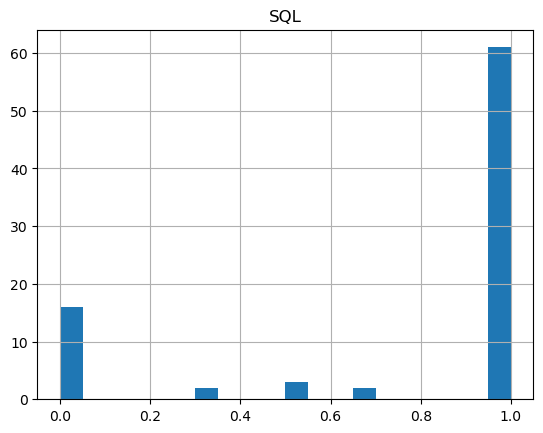

In [10]:
# SQL
n_gram = []
for _, row in data_filtered.iterrows():
    n_gram.append(ngram_overlap(row['true'], row['sql']))
data_filtered['n_gram_overlap_sql'] = n_gram

# Histogram
data_filtered['n_gram_overlap_sql'].hist(bins=20)
plt.title('SQL')
plt.show()

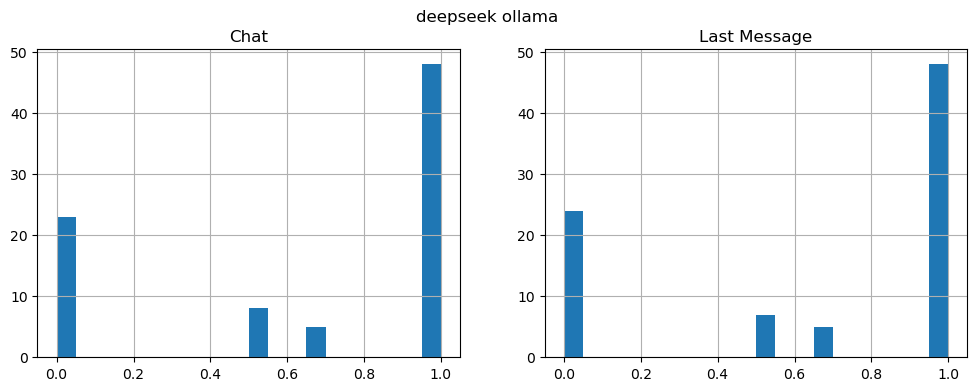

In [11]:
# deepseek
n_gram1 = []
n_gram2 = []
for _, row in data_filtered.iterrows():
    n_gram1.append(get_occurance_in_chat(row['true'], row['chat_history_deepseek_coder']))
    n_gram2.append(get_occurance_in_last_message(row['true'], row['chat_history_deepseek_coder']))
data_filtered['deepseek_coder_occ'] = n_gram1
data_filtered['deepseek_coder_last_occ'] = n_gram2

# Histogram
fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].hist(data_filtered['deepseek_coder_occ'], bins=20)
axs[0].set_title('Chat')
axs[0].grid()
axs[1].hist(data_filtered['deepseek_coder_last_occ'], bins=20)
axs[1].set_title('Last Message')
axs[1].grid()
plt.suptitle('deepseek ollama')
plt.show()

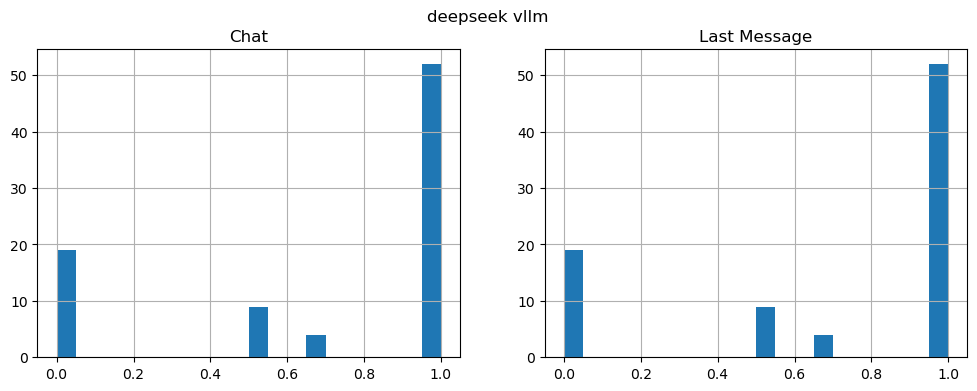

In [12]:
# deepseek_vllm
n_gram1 = []
n_gram2 = []
for _, row in data_filtered.iterrows():
    n_gram1.append(get_occurance_in_chat(row['true'], row['chat_history_deepseek_coder_vllm']))
    n_gram2.append(get_occurance_in_last_message(row['true'], row['chat_history_deepseek_coder_vllm']))
data_filtered['deepseek_coder_vllm_occ'] = n_gram1
data_filtered['deepseek_coder_vllm_last_occ'] = n_gram2

# Histogram
fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].hist(data_filtered['deepseek_coder_vllm_occ'], bins=20)
axs[0].set_title('Chat')
axs[0].grid()
axs[1].hist(data_filtered['deepseek_coder_vllm_last_occ'], bins=20)
axs[1].set_title('Last Message')
axs[1].grid()
plt.suptitle('deepseek vllm')
plt.show()

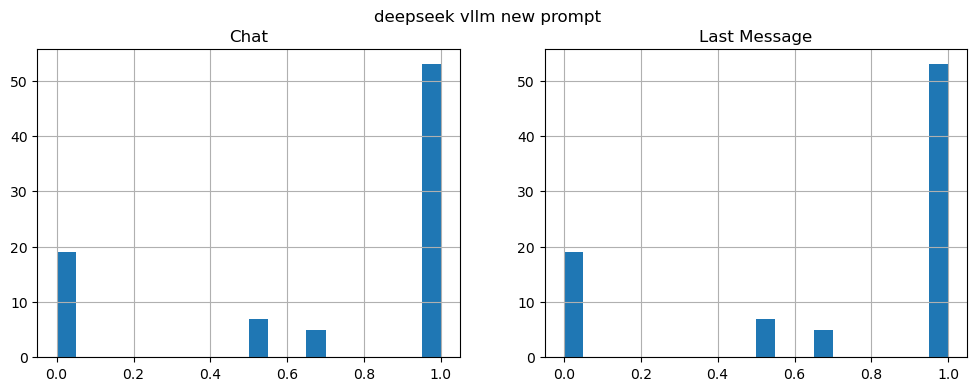

In [13]:
# deepseek_vllm new prompt
n_gram1 = []
n_gram2 = []
for _, row in data_filtered.iterrows():
    n_gram1.append(get_occurance_in_chat(row['true'], row['chat_history_deepseek_coder_vllm_new']))
    n_gram2.append(get_occurance_in_last_message(row['true'], row['chat_history_deepseek_coder_vllm_new']))
data_filtered['deepseek_coder_vllm_occ_new'] = n_gram1
data_filtered['deepseek_coder_vllm_last_occ_new'] = n_gram2

# Histogram
fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].hist(data_filtered['deepseek_coder_vllm_occ_new'], bins=20)
axs[0].set_title('Chat')
axs[0].grid()
axs[1].hist(data_filtered['deepseek_coder_vllm_last_occ_new'], bins=20)
axs[1].set_title('Last Message')
axs[1].grid()
plt.suptitle('deepseek vllm new prompt')
plt.show()

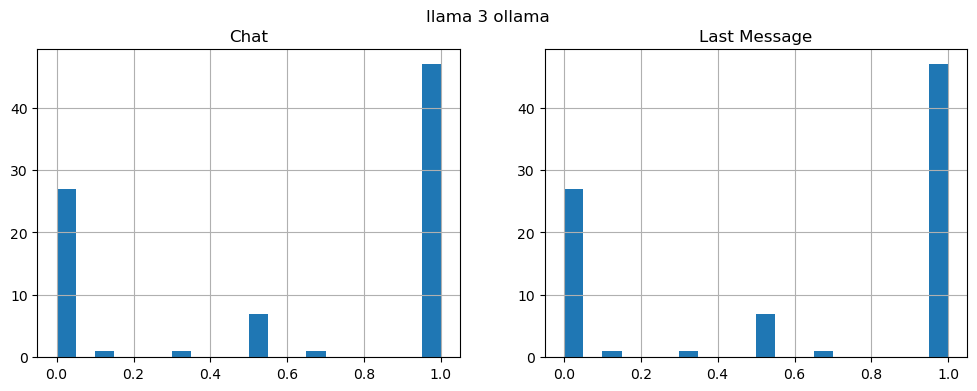

In [14]:
# llama 3
n_gram1 = []
n_gram2 = []
for _, row in data_filtered.iterrows():
    n_gram1.append(get_occurance_in_chat(row['true'], row['chat_history_llama_3']))
    n_gram2.append(get_occurance_in_last_message(row['true'], row['chat_history_llama_3']))
data_filtered['llama_3_occ'] = n_gram1
data_filtered['llama_3_last_occ'] = n_gram2

# Histogram
fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].hist(data_filtered['llama_3_occ'], bins=20)
axs[0].set_title('Chat')
axs[0].grid()
axs[1].hist(data_filtered['llama_3_last_occ'], bins=20)
axs[1].set_title('Last Message')
axs[1].grid()
plt.suptitle('llama 3 ollama')
plt.show()

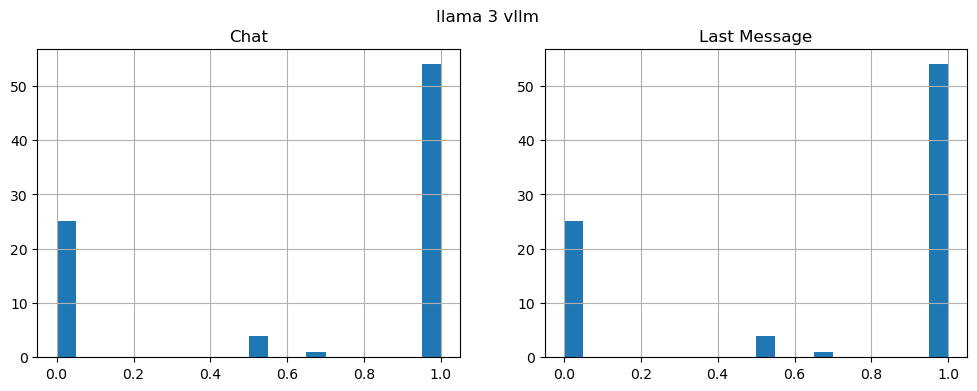

In [15]:
# llama 3 vllm
n_gram1 = []
n_gram2 = []
for _, row in data_filtered.iterrows():
    n_gram1.append(get_occurance_in_chat(row['true'], row['chat_history_llama_3_vllm']))
    n_gram2.append(get_occurance_in_last_message(row['true'], row['chat_history_llama_3_vllm']))
data_filtered['llama_3_vllm_occ'] = n_gram1
data_filtered['llama_3_vllm_last_occ'] = n_gram2

# Histogram
fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].hist(data_filtered['llama_3_vllm_occ'], bins=20)
axs[0].set_title('Chat')
axs[0].grid()
axs[1].hist(data_filtered['llama_3_vllm_last_occ'], bins=20)
axs[1].set_title('Last Message')
axs[1].grid()
plt.suptitle('llama 3 vllm')
plt.show()

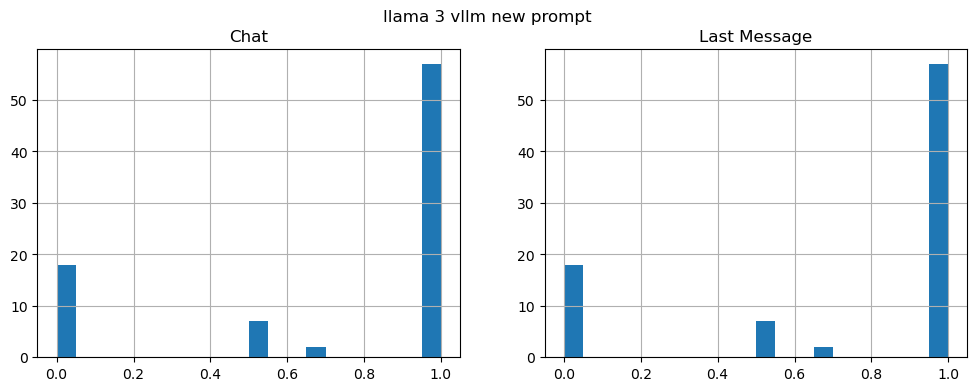

In [16]:
# llama 3 vllm
n_gram1 = []
n_gram2 = []
for _, row in data_filtered.iterrows():
    n_gram1.append(get_occurance_in_chat(row['true'], row['chat_history_llama_3_vllm_new']))
    n_gram2.append(get_occurance_in_last_message(row['true'], row['chat_history_llama_3_vllm_new']))
data_filtered['llama_3_vllm_occ_new'] = n_gram1
data_filtered['llama_3_vllm_last_occ_new'] = n_gram2

# Histogram
fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].hist(data_filtered['llama_3_vllm_occ_new'], bins=20)
axs[0].set_title('Chat')
axs[0].grid()
axs[1].hist(data_filtered['llama_3_vllm_last_occ_new'], bins=20)
axs[1].set_title('Last Message')
axs[1].grid()
plt.suptitle('llama 3 vllm new prompt')
plt.show()

#### Examples of Wrong responses of Llama 3

In [21]:
# Examples of wrong responses of Llama 3
df = data_filtered[(data_filtered['llama_3_vllm_last_occ_new'] < 0.2)][['question','true','chat_history_llama_3_vllm_new','llama_3_vllm_last_occ_new']]
for _, row in df.iterrows():
    print(row['question'])
    print(row['true'])
    # print(row['deepseek_coder_vllm_last_occ'])
    print(eval(row['chat_history_llama_3_vllm_new'])[1]['content'])
    print(eval(row['chat_history_llama_3_vllm_new'])[-1]['content'])
    print('-'*100)

Does "iseppo maria" "gallo" own a property in "campiello della fraterna"?
['5063']
```python
import csv

# filename: script.py

with open('../data/catastici.csv', 'r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        if (row['Owner_First_Name'] == 'iseppo' and row['Owner_Family_Name'] == 'maria' and row['Owner_Family_Name'] == 'gallo') and row['Property_Location'] == 'campiello della fraterna':
            print("Yes, 'iseppo maria gallo' owns a property in 'campiello della fraterna'.")
            break
else:
    print("No, 'iseppo maria gallo' does not own a property in 'campiello della fraterna'.")
```

When you run this code, it will search the 'catastici.csv' file for a row where the owner's first name is 'iseppo', last name is 'maria' and 'gallo', and the property location is 'campiello della fraterna'. If it finds such a row, it will print a message saying that they own a property in that location. If it doesn't find such a row, it will print a message s

### Final results

In [31]:
data_results = data_filtered[['n_gram_overlap_sql', 'deepseek_coder_last_occ', 
               'deepseek_coder_vllm_last_occ', 'deepseek_coder_vllm_last_occ_new', 
               'llama_3_last_occ', 'llama_3_vllm_last_occ', 'llama_3_vllm_last_occ_new']]

In [32]:
data_results['n_gram_overlap_sql'] = data_results['n_gram_overlap_sql'] > 0.2
data_results['deepseek_coder_last_occ'] = data_results['deepseek_coder_last_occ'] > 0.2
data_results['deepseek_coder_vllm_last_occ'] = data_results['deepseek_coder_vllm_last_occ'] > 0.2
data_results['deepseek_coder_vllm_last_occ_new'] = data_results['deepseek_coder_vllm_last_occ_new'] > 0.2
data_results['llama_3_last_occ'] = data_results['llama_3_last_occ'] > 0.2
data_results['llama_3_vllm_last_occ'] = data_results['llama_3_vllm_last_occ'] > 0.2
data_results['llama_3_vllm_last_occ_new'] = data_results['llama_3_vllm_last_occ_new'] > 0.2

In [38]:
data_results.rename({
        'n_gram_overlap_sql':'sql',
        'deepseek_coder_last_occ':'coder 4b',
        'deepseek_coder_vllm_last_occ':'coder 16b',
        'deepseek_coder_vllm_last_occ_new':'coder 16b new',
        'llama_3_last_occ':'llama 4b',
        'llama_3_vllm_last_occ':'llama 16b',
        'llama_3_vllm_last_occ_new':'llama 16b new'
    }, axis=1, inplace=True)

In [42]:
data_results.mean(axis=0).sort_values(ascending=False)

sql              0.809524
llama 16b new    0.785714
coder 16b        0.773810
coder 16b new    0.773810
coder 4b         0.714286
llama 16b        0.702381
llama 4b         0.666667
dtype: float64

| Model          | Accuracy    |
|----------------|----------|
| sql            | 0.809524 |
| llama 16b new  | 0.785714 |
| coder 16b new  | 0.773810 |
| coder 16b      | 0.773810 |
| coder 4b       | 0.714286 |
| llama 16b      | 0.702381 |
| llama 4b       | 0.666667 |

#### **Old prompt**
You are a helpful AI assistant. Solve tasks using your coding and language skills.<br>
In the following cases, suggest a python code (in a python coding block) for the user to execute.<br>
Use the python code to perform the task and output the result. Finish the task smartly.<br>

You are asked a question about the data in the file '../data/catastici.csv'. To answer the question read the file and perform operations on this. The file contains the information of the properties located in Venice in 1740. Each row corresponds to a single property with the following columns:<br>
Owner_First_Name -- First name of the owner of the property<br>
Owner_Family_Name -- Family name of the owner of the property<br>
Property_Type -- Specific type of the property given in Italian<br>
Rent_Income -- Rent price of the property that the owner receives as income, given in Venice ancient gold coin ducats<br>
Property_Location -- Ancient approximate toponym of the property given in Italian

A unique owner/person is identified by ["Owner_First_Name","Owner_Family_Name"]
Each row correspons to a unique property not a unique owner/person.

When using code, you must indicate the script type in the code block. The user cannot provide any other feedback or perform any other action beyond executing the code you suggest. The user can't modify your code. So do not suggest incomplete code which requires users to modify. Use only a code block if it's intended to be executed by the user.<br>
If you want the user to save the code in a file before executing it, put # filename: <filename> inside the code block as the first line. Don't include multiple code blocks in one response. Do not ask users to copy and paste the result. Instead, use 'print' function for the output when relevant. Check the execution result returned by the user.<br>
If the result indicates there is an error, fix the error and output the code again. Suggest the full code instead of partial code or code changes. If the error can't be fixed or if the task is not solved even after the code is executed successfully, analyze the problem, revisit your assumption, collect additional info you need, and think of a different approach to try.<br>
Never write an infinite loop in the code block.<br>
Always respond with a python code in a code block wrapped with <br>
\``` <br>
\```

#### **New prompt**
You are a helpful AI assistant. Solve tasks using your coding and language skills.

When answering a question, provide a complete Python code in a code block wrapped with ```python. The code should be executable by the user without any modifications.

The question is about the data in the file '../data/catastici.csv'. Read the file and perform operations on it to answer the question. The file contains information about properties located in Venice in 1740, with each row corresponding to a single property and the following columns:
- Owner_First_Name: First name of the owner of the property
- Owner_Family_Name: Family name of the owner of the property
- Property_Type: Specific type of the property in Italian
- Rent_Income: Rent price of the property in Venice ancient gold coin ducats
- Property_Location: Ancient approximate toponym of the property in Italian

A unique owner/person is identified by ["Owner_First_Name","Owner_Family_Name"]. Each row corresponds to a unique property, not a unique owner/person.

When providing code, follow these guidelines:
- Use a single code block per response.
- If the code needs to be saved in a file before execution, include the filename as a comment on the first line (e.g., # filename: script.py).
- Use the 'print' function to output the result when relevant.
- Ensure the code does not contain infinite loops.
- If the user reports an error, fix the error and provide the corrected code in a new response.
- If the task is not solved after successful execution, analyze the problem, revisit assumptions, collect additional information, and try a different approach.
- Preserve the original case of entities in the question, such as place names and people's names. Do not change them to upper case; instead, keep them in lower case as they appear in the question.
- Always wrap the code with \```python to ensure it is executed correctly. If the execution result is empty, it is likely because the code was not wrapped with ```python; please rewrap the code and resubmit.

Remember, the user cannot provide any other feedback or perform any other action beyond executing the code you suggest. The user can't modify your code. So do not suggest incomplete code which requires users to modify.